In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm

from scipy.stats import pearsonr

In [122]:
train = pd.read_csv('../data/olfaction_mixture/Mixure_Definitions_Training_set.csv')
lead = pd.read_csv('../data/olfaction_mixture/Mixure_Definitions_Leaderboard_set.csv')
test = pd.read_csv('../data/olfaction_mixture/Mixure_Definitions_test_set.csv')
train.index = train['Dataset'] + "_" + train['Mixture Label'].astype(str)
train = train.iloc[:, 2:]
lead.index = lead['Dataset'] + "_" + lead['Mixture Label'].astype(str)
lead = lead.iloc[:, 2:]
test.index = test['Mixture Label'].astype(str)
test = test.iloc[:, 1:]

In [123]:
mono = pd.read_csv('../results/features/mono-descriptors-v1.csv', index_col=0)
mono = (mono - mono.mean()) / mono.std()

In [124]:
cid_dict = {}
for m in train.index:
    cids = train.loc[m]
    cids = cids.values[cids.values!=0]
    cid_dict[m] = list(set(cids) & set(mono.index))
for m in test.index:
    cids = test.loc[m]
    cids = cids.values[cids.values!=0]
    cid_dict[m] = list(set(cids) & set(mono.index))

### Simple RF model
We take the features of the mixtrues, concatenate them for the two mixtures of a training example and predict the target variable (similarity).

TODO: as test mixtures are new (not present in train / leaderboard), some mixture exclusive testing would be interesting

In [125]:
### we make a zscore normalization of the features, some models like it
features = pd.read_csv('../results/features/mix-descriptors-v1.csv', index_col=0)
features = (features - features.mean()) / features.std()

In [126]:
mono = pd.read_csv('../results/features/mono-descriptors-v1.csv', index_col=0)
mono = (mono - mono.mean()) / mono.std()

In [127]:
train = pd.read_csv('../data/olfaction_mixture/TrainingData_mixturedist.csv')
fil = train.isna().sum(1) == 0
train = train[fil]
train['Mixture 1'] = train['Dataset'].astype(str) + '_' + train['Mixture 1'].astype(int).astype(str)
train['Mixture 2'] = train['Dataset'].astype(str) + '_' + train['Mixture 2'].astype(int).astype(str)
del train['Dataset']
train['Name'] = train['Mixture 1'] + ' / ' + train['Mixture 2']
train.head()

,Mixture 1,Mixture 2,Experimental Values,Name
0,Snitz 1_1,Snitz 1_2,0.604167,Snitz 1_1 / Snitz 1_2
1,Snitz 1_1,Snitz 1_3,0.651042,Snitz 1_1 / Snitz 1_3
2,Snitz 1_1,Snitz 1_5,0.505208,Snitz 1_1 / Snitz 1_5
3,Snitz 1_1,Snitz 1_6,0.411458,Snitz 1_1 / Snitz 1_6
4,Snitz 1_1,Snitz 1_7,0.562500,Snitz 1_1 / Snitz 1_7


In [135]:
np.random.seed(19)
tr = np.random.choice(train.index, 400, False).tolist()
ts = list(set(train.index) - set(tr))
len(tr), len(ts)

(400, 100)

In [136]:
data_tr = train.loc[tr]
data_ts = train.loc[ts]

In [137]:
### we will duplicate the dataset to make it invariant to the orders of mixture 1 / 2
def duplicate_dataset(data):
    data_ = data.copy()
    data_['Mixture 1'] = data['Mixture 2']
    data_['Mixture 2'] = data['Mixture 1']
    data_ = pd.concat([data, data_])
    data_.index = range(len(data_))
    return data_

In [138]:
data_tr = duplicate_dataset(data_tr)
data_ts = duplicate_dataset(data_ts)

In [139]:
sim_features_tr = pd.DataFrame(columns=[str(x) for x in range(8)], index=data_tr.index)
for i in data_tr.index:
    mix1 = data_tr.loc[i, 'Mixture 1']
    mix2 = data_tr.loc[i, 'Mixture 2']
    cids1 = list(cid_dict[mix1])
    cids2 = list(cid_dict[mix2])
    temp = mono.loc[cids1+cids2]
    temp = temp.T.corr()
    temp = temp.loc[cids1, cids2]
    sim_features_tr.loc[i] = [temp.min(0).min(), temp.min(1).min(),
                             temp.max(0).min(), temp.max(1).min(),
                             temp.min(0).max(), temp.min(1).max(),
                             temp.max(0).max(), temp.max(1).max()]
sim_features_ts = pd.DataFrame(columns=[str(x) for x in range(8)], index=data_ts.index)
for i in data_ts.index:
    mix1 = data_ts.loc[i, 'Mixture 1']
    mix2 = data_ts.loc[i, 'Mixture 2']
    cids1 = list(cid_dict[mix1])
    cids2 = list(cid_dict[mix2])
    temp = mono.loc[cids1+cids2]
    temp = temp.T.corr()
    temp = temp.loc[cids1, cids2]
    sim_features_ts.loc[i] = [temp.min(0).min(), temp.min(1).min(),
                             temp.max(0).min(), temp.max(1).min(),
                             temp.min(0).max(), temp.min(1).max(),
                             temp.max(0).max(), temp.max(1).max()]

In [146]:
### features of the first mixture
X_tr1 = features.loc[data_tr['Mixture 1'].values]
X_tr1.index = data_tr.index
### features of the second mixture
X_tr2 = features.loc[data_tr['Mixture 2'].values]
X_tr2.index = data_tr.index

X_tr = pd.concat([X_tr1, X_tr2], axis=1)

In [147]:
### same for test
X_ts1 = features.loc[data_ts['Mixture 1'].values]
X_ts1.index = data_ts.index

X_ts2 = features.loc[data_ts['Mixture 2'].values]
X_ts2.index = data_ts.index

X_ts = pd.concat([X_ts1, X_ts2], axis=1)

In [148]:
model = RandomForestRegressor(n_estimators=300, n_jobs=-1)
model.fit(X_tr, data_tr['Experimental Values'])

RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [149]:
y_pr = model.predict(X_ts)
data_ts['pred'] = y_pr

In [150]:
### average the 2 predictions for each mixture
results = data_ts[['Name', 'Experimental Values', 'pred']].groupby('Name').mean()

PearsonRResult(statistic=0.44855473164181414, pvalue=2.864253030039294e-06)

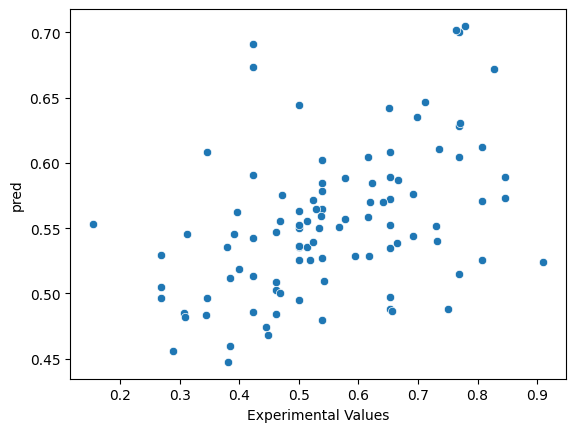

In [151]:
sns.scatterplot(x=results['Experimental Values'],
               y=results['pred'])
pearsonr(x=results['Experimental Values'],
               y=results['pred'])

looks okayish, so let's do the prediction for leaderboard and test sets.

### Pred for leaderboard and test

In [152]:
lead = pd.read_csv('../data/olfaction_mixture/Leaderboard_set_Submission_form.csv')
lead['Mixture 1'] = lead['Dataset'].astype(str) + '_' + lead['Mixture_1'].astype(int).astype(str)
lead['Mixture 2'] = lead['Dataset'].astype(str) + '_' + lead['Mixture_2'].astype(int).astype(str)
del lead['Dataset']
del lead['Mixture_1']
del lead['Mixture_2']
lead['Name'] = lead['Mixture 1'] + ' / ' + lead['Mixture 2']
lead.head()

,Predicted_Experimental_Values,Mixture 1,Mixture 2,Name
0,0,Bushdid_65,Bushdid_66,Bushdid_65 / Bushdid_66
1,0,Snitz 2_1,Snitz 2_8,Snitz 2_1 / Snitz 2_8
2,0,Snitz 1_24,Snitz 1_17,Snitz 1_24 / Snitz 1_17
3,0,Snitz 2_12,Snitz 2_14,Snitz 2_12 / Snitz 2_14
4,0,Snitz 1_49,Snitz 1_45,Snitz 1_49 / Snitz 1_45


In [153]:
test = pd.read_csv('../data/olfaction_mixture/Test_set_Submission_form.csv')
test['Mixture 1'] = test['Mixture_1'].astype(int).astype(str)
test['Mixture 2'] = test['Mixture_2'].astype(int).astype(str)
del test['Dataset']
del test['Mixture_1']
del test['Mixture_2']
test['Name'] = test['Mixture 1'] + ' / ' + test['Mixture 2']
test.head()

,Predicted_Experimental_Values,Mixture 1,Mixture 2,Name
0,0,1,17,1 / 17
1,0,2,18,2 / 18
2,0,3,19,3 / 19
3,0,4,20,4 / 20
4,0,5,21,5 / 21


In [154]:
train = duplicate_dataset(train)
lead = duplicate_dataset(lead)
test = duplicate_dataset(test)

In [159]:
sim_features_tr = pd.DataFrame(columns=[str(x) for x in range(8)], index=train.index)
for i in train.index:
    mix1 = train.loc[i, 'Mixture 1']
    mix2 = train.loc[i, 'Mixture 2']
    cids1 = list(cid_dict[mix1])
    cids2 = list(cid_dict[mix2])
    temp = mono.loc[cids1+cids2]
    temp = temp.T.corr()
    temp = temp.loc[cids1, cids2]
    sim_features_tr.loc[i] = [temp.min(0).min(), temp.min(1).min(),
                             temp.max(0).min(), temp.max(1).min(),
                             temp.min(0).max(), temp.min(1).max(),
                             temp.max(0).max(), temp.max(1).max()]
sim_features_lead = pd.DataFrame(columns=[str(x) for x in range(8)], index=lead.index)
for i in lead.index:
    mix1 = lead.loc[i, 'Mixture 1']
    mix2 = lead.loc[i, 'Mixture 2']
    cids1 = list(cid_dict[mix1])
    cids2 = list(cid_dict[mix2])
    temp = mono.loc[cids1+cids2]
    temp = temp.T.corr()
    temp = temp.loc[cids1, cids2]
    sim_features_lead.loc[i] = [temp.min(0).min(), temp.min(1).min(),
                             temp.max(0).min(), temp.max(1).min(),
                             temp.min(0).max(), temp.min(1).max(),
                             temp.max(0).max(), temp.max(1).max()]

sim_features_test = pd.DataFrame(columns=[str(x) for x in range(8)], index=test.index)
for i in test.index:
    mix1 = test.loc[i, 'Mixture 1']
    mix2 = test.loc[i, 'Mixture 2']
    cids1 = list(cid_dict[mix1])
    cids2 = list(cid_dict[mix2])
    temp = mono.loc[cids1+cids2]
    temp = temp.T.corr()
    temp = temp.loc[cids1, cids2]
    sim_features_test.loc[i] = [temp.min(0).min(), temp.min(1).min(),
                             temp.max(0).min(), temp.max(1).min(),
                             temp.min(0).max(), temp.min(1).max(),
                             temp.max(0).max(), temp.max(1).max()]

In [163]:
sim_features_lead

,0,1,2,3,4,5,6,7
0,-0.831235,-0.831235,0.544144,0.544144,-0.359631,-0.401228,1.0,1.0
1,-0.744156,-0.744156,0.207975,0.303249,-0.044063,-0.20703,0.557444,0.557444
2,-0.775773,-0.775773,-0.129174,0.506706,-0.126426,-0.378551,0.931125,0.931125
3,-0.725117,-0.725117,0.391416,0.210388,-0.34457,-0.482219,0.815763,0.815763
4,-0.362974,-0.362974,0.761247,-0.362974,-0.362974,0.761247,0.761247,0.761247
...,...,...,...,...,...,...,...,...
87,-0.836768,-0.836768,0.448208,0.383806,-0.298482,-0.374716,1.0,1.0
88,-0.805344,-0.805344,0.747664,0.350337,-0.407125,-0.072248,1.0,1.0
89,-0.813277,-0.813277,0.758374,0.842407,-0.407921,-0.407921,1.0,1.0
90,-0.92294,-0.92294,0.534815,0.513439,-0.440004,-0.322193,1.0,1.0


In [165]:
### train features
X_tr1 = features.loc[train['Mixture 1'].values]
X_tr1.index = train.index

X_tr2 = features.loc[train['Mixture 2'].values]
X_tr2.index = train.index

X_tr = pd.concat([X_tr1, X_tr2, sim_features_tr], axis=1)

In [166]:
### leaderoard features
X_lb1 = features.loc[lead['Mixture 1'].values]
X_lb1.index = lead.index

X_lb2 = features.loc[lead['Mixture 2'].values]
X_lb2.index = lead.index

X_lb = pd.concat([X_lb1, X_lb2, sim_features_lead], axis=1)

In [167]:
### test features
X_ts1 = features.loc[test['Mixture 1'].values]
X_ts1.index = test.index

X_ts2 = features.loc[test['Mixture 2'].values]
X_ts2.index = test.index

X_ts = pd.concat([X_ts1, X_ts2, sim_features_test], axis=1)

In [168]:
model = RandomForestRegressor(n_estimators=300, n_jobs=-1)
model.fit(X_tr, train['Experimental Values'])

RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [169]:
lead['Predicted_Experimental_Values'] = model.predict(X_lb)
test['Predicted_Experimental_Values'] = model.predict(X_ts)

In [170]:
lead = lead[['Name', 'Predicted_Experimental_Values']].groupby('Name').mean()
test = test[['Name', 'Predicted_Experimental_Values']].groupby('Name').mean()

Now let's do the submission files.

In [171]:
sub_lead = pd.read_csv('../data/olfaction_mixture/Leaderboard_set_Submission_form.csv')
sub_test = pd.read_csv('../data/olfaction_mixture/Test_set_Submission_form.csv')

In [172]:
sub_lead.index = sub_lead['Dataset'] + '_' + sub_lead['Mixture_1'].astype(str) + ' / ' + sub_lead['Dataset'] + '_' + sub_lead['Mixture_2'].astype(str)
sub_test.index = sub_test['Mixture_1'].astype(str) + ' / ' + sub_test['Mixture_2'].astype(str)

In [173]:
sub_lead['Predicted_Experimental_Values'] = lead.loc[sub_lead.index]['Predicted_Experimental_Values']
sub_test['Predicted_Experimental_Values'] = test.loc[sub_test.index]['Predicted_Experimental_Values']

In [174]:
sub_lead.to_csv('../results/submissions/second-version-lead.csv', index=False)
sub_test.to_csv('../results/submissions/second-version-test.csv', index=False)

In [197]:
temp = pd.read_csv('../results/submissions/first-version-test.csv')
temp.index = sub_test.index

In [200]:
sub_test['Predicted_Experimental_Values'] = sub_test['Predicted_Experimental_Values'] + temp['Predicted_Experimental_Values']
sub_test['Predicted_Experimental_Values'] = sub_test['Predicted_Experimental_Values'] / 2

In [201]:
sub_test.to_csv('../results/submissions/third-version-test.csv', index=False)

<Axes: >

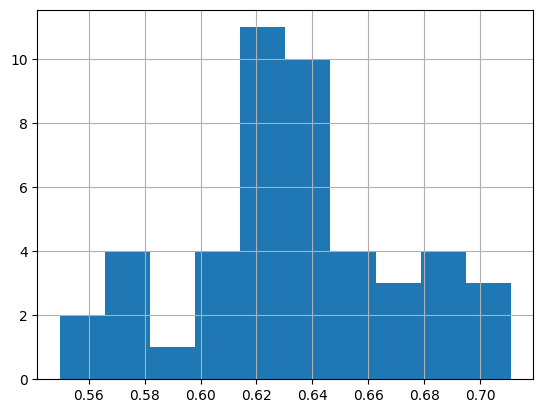

In [203]:
sub_test['Predicted_Experimental_Values'].hist()

<Axes: >

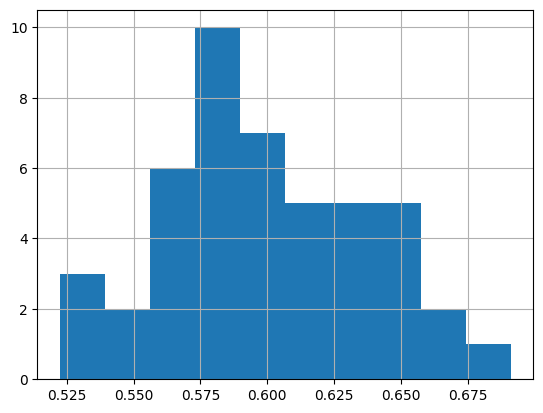

In [204]:
temp['Predicted_Experimental_Values'].hist()